C:\Users\ASUS\AppData\Local\Temp\ipykernel_8536\1646282373.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_parsed'] = pd.to_datetime(df.get('date', pd.Series(pd.NA)), errors='coerce', dayfirst=True, infer_datetime_format=True)


Transactions: 3,547
Total revenue: 112,245.58

Top 10 by Product (Revenue):
        coffee_name  revenue
              Latte 26875.30
Americano with Milk 24751.12
         Cappuccino 17439.14
          Americano 14650.26
      Hot Chocolate  9933.46
              Cocoa  8521.16
            Cortado  7384.86
           Espresso  2690.28

Revenue by Payment Type:
cash_type   revenue
     card 112245.58

Revenue by Daypart:
time_of_day  revenue
      Night 38186.34
  Afternoon 38130.04
    Morning 35929.20

Revenue by Weekday:
weekday  revenue
    Mon 17363.10
    Tue 18168.38
    Wed 15750.46
    Thu 16091.40
    Fri 16802.66
    Sat 14733.52
    Sun 13336.06

Revenue by Month:
month_name  revenue
   January  6398.86
  February 13215.48
     March 15891.64
     April  5719.56
       May  8164.42
      June  7617.76
      July  6915.94
    August  7613.84
 September  9988.64
   October 13891.16
  November  8590.54
  December  8237.74

Revenue by Hour:
 hour_of_day  revenue
          10 101

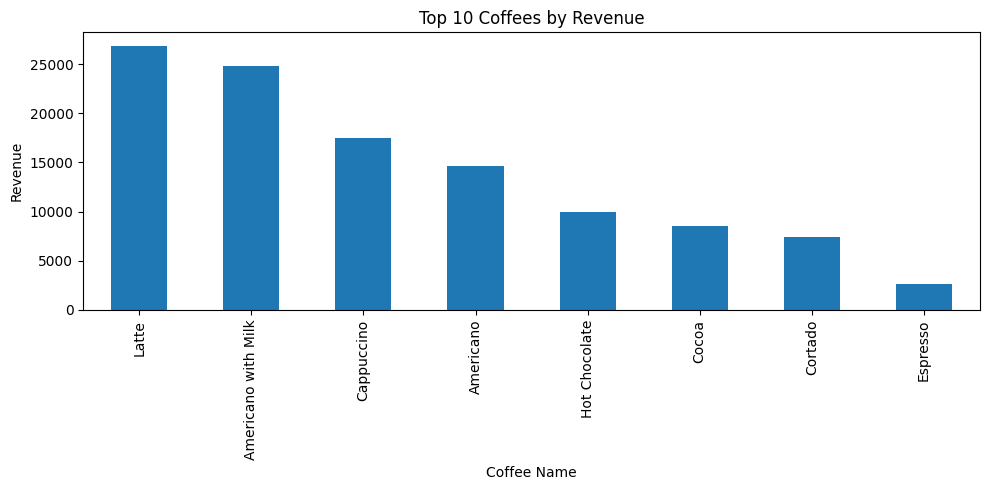

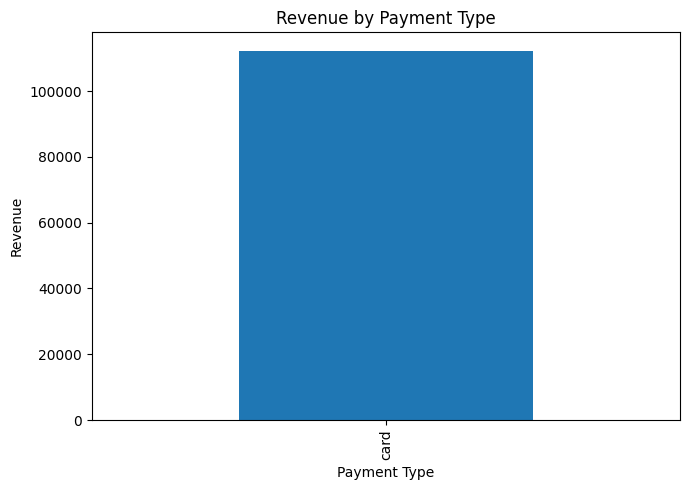

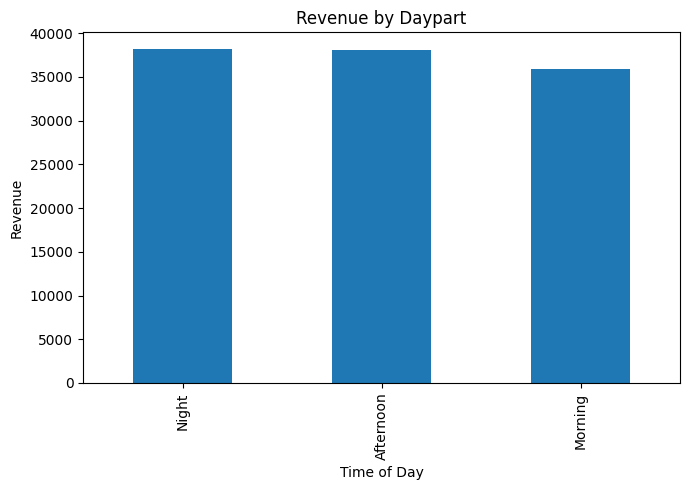

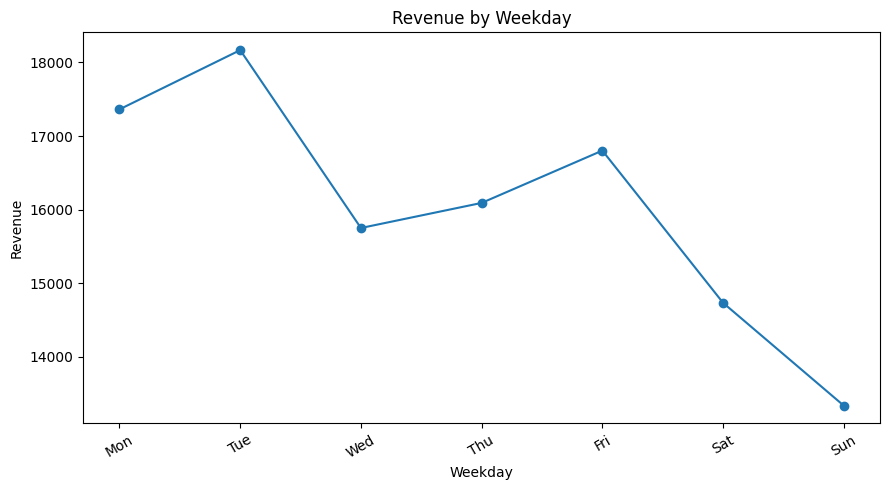

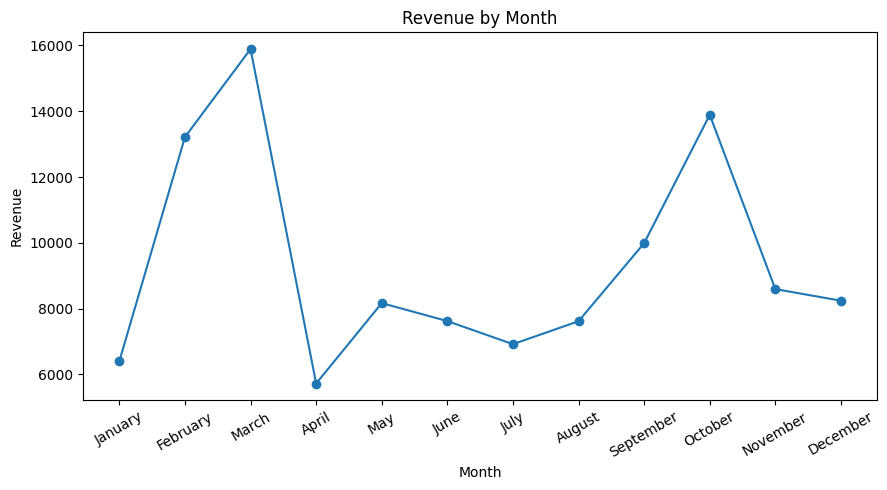

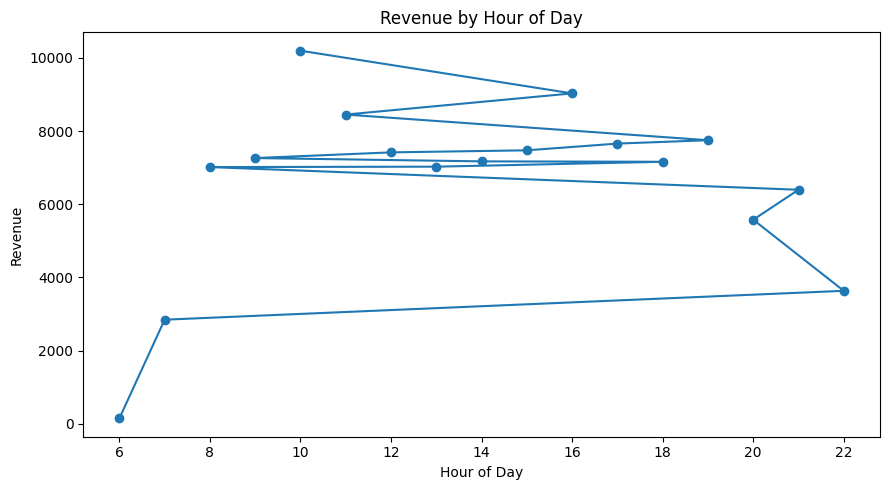


Saved cleaned file: coffee_sales_cleaned_v2.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Load ----------
df = pd.read_csv("C:\\Users\\ASUS\\Downloads\\coffee_sales_cleaned_v2.csv")

df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]

# ---------- Parse ----------
# Revenue
if 'money' in df.columns:
    df['revenue'] = pd.to_numeric(df['money'].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')

# Date
df['date_parsed'] = pd.to_datetime(df.get('date', pd.Series(pd.NA)), errors='coerce', dayfirst=True, infer_datetime_format=True)
if df['date_parsed'].notna().sum() < 0.5 * len(df):
    df['date_parsed'] = pd.to_datetime(df.get('date', pd.Series(pd.NA)), errors='coerce')

# Time features
if df['date_parsed'].notna().any():
    df['year'] = df['date_parsed'].dt.year
    df['month'] = df['date_parsed'].dt.month
    df['day'] = df['date_parsed'].dt.day
    df['month_name'] = df['date_parsed'].dt.month_name()

# ---------- Dimensions ----------
dims = {
    'product': 'coffee_name' if 'coffee_name' in df.columns else None,
    'payment': 'cash_type' if 'cash_type' in df.columns else None,
    'daypart': 'time_of_day' if 'time_of_day' in df.columns else None,
    'weekday': 'weekday' if 'weekday' in df.columns else None,
    'hour': 'hour_of_day' if 'hour_of_day' in df.columns else None,
    'month_name': 'month_name' if 'month_name' in df.columns else None,
}

# ---------- KPIs ----------
total_revenue = df['revenue'].sum() if 'revenue' in df.columns else np.nan
n_txns = len(df)

print(f"Transactions: {n_txns:,}")
print(f"Total revenue: {total_revenue:,.2f}")

# ---------- Tables ----------
def top_table(series_name, group_col, k=10):
    g = df.groupby(group_col)['revenue'].sum().sort_values(ascending=False).head(k).reset_index()
    print(f"\nTop {k} by {series_name} (Revenue):")
    print(g.to_string(index=False))
    return g

if dims['product'] and 'revenue' in df.columns:
    top_products = top_table('Product', dims['product'])

if dims['payment'] and 'revenue' in df.columns:
    pay = df.groupby(dims['payment'])['revenue'].sum().sort_values(ascending=False).reset_index()
    print("\nRevenue by Payment Type:")
    print(pay.to_string(index=False))

if dims['daypart'] and 'revenue' in df.columns:
    dp = df.groupby(dims['daypart'])['revenue'].sum().sort_values(ascending=False).reset_index()
    print("\nRevenue by Daypart:")
    print(dp.to_string(index=False))

if dims['weekday'] and 'revenue' in df.columns:
    if 'weekdaysort' in df.columns:
        wd = (df.groupby(['weekdaysort', dims['weekday']])['revenue'].sum()
                .reset_index().sort_values('weekdaysort'))[[dims['weekday'], 'revenue']]
    else:
        wd = df.groupby(dims['weekday'])['revenue'].sum().sort_values(ascending=False).reset_index()
    print("\nRevenue by Weekday:")
    print(wd.to_string(index=False))

if dims['month_name'] and 'revenue' in df.columns:
    if 'monthsort' in df.columns:
        mo = (df.groupby(['monthsort', dims['month_name']])['revenue'].sum()
                .reset_index().sort_values('monthsort'))[[dims['month_name'], 'revenue']]
    else:
        mo = df.groupby(dims['month_name'])['revenue'].sum().sort_values(ascending=False).reset_index()
    print("\nRevenue by Month:")
    print(mo.to_string(index=False))

if dims['hour'] and 'revenue' in df.columns:
    hr = df.groupby(dims['hour'])['revenue'].sum().sort_values(ascending=False).reset_index()
    print("\nRevenue by Hour:")
    print(hr.to_string(index=False))

# ---------- Charts (single plots, no seaborn, default colors) ----------
if dims['product'] and 'revenue' in df.columns:
    s = df.groupby(dims['product'])['revenue'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    s.plot(kind='bar')
    plt.title("Top 10 Coffees by Revenue")
    plt.xlabel("Coffee Name")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

if dims['payment'] and 'revenue' in df.columns:
    s = df.groupby(dims['payment'])['revenue'].sum().sort_values(ascending=False)
    plt.figure(figsize=(7,5))
    s.plot(kind='bar')
    plt.title("Revenue by Payment Type")
    plt.xlabel("Payment Type")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

if dims['daypart'] and 'revenue' in df.columns:
    s = df.groupby(dims['daypart'])['revenue'].sum().sort_values(ascending=False)
    plt.figure(figsize=(7,5))
    s.plot(kind='bar')
    plt.title("Revenue by Daypart")
    plt.xlabel("Time of Day")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

if dims['weekday'] and 'revenue' in df.columns:
    if 'weekdaysort' in df.columns:
        ordered = (df.groupby(['weekdaysort', dims['weekday']])['revenue'].sum().reset_index()
                   .sort_values('weekdaysort'))
        plt.figure(figsize=(9,5))
        plt.plot(ordered[dims['weekday']], ordered['revenue'], marker='o')
        plt.title("Revenue by Weekday")
        plt.xlabel("Weekday")
        plt.ylabel("Revenue")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

if dims['month_name'] and 'revenue' in df.columns:
    if 'monthsort' in df.columns:
        ordered = (df.groupby(['monthsort', dims['month_name']])['revenue'].sum().reset_index()
                   .sort_values('monthsort'))
        plt.figure(figsize=(9,5))
        plt.plot(ordered[dims['month_name']], ordered['revenue'], marker='o')
        plt.title("Revenue by Month")
        plt.xlabel("Month")
        plt.ylabel("Revenue")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

if dims['hour'] and 'revenue' in df.columns:
    s = df.groupby(dims['hour'])['revenue'].sum().sort_values(ascending=False)
    plt.figure(figsize=(9,5))
    plt.plot(s.index, s.values, marker='o')
    plt.title("Revenue by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

# ---------- Save cleaned ----------
df.to_csv("coffee_sales_cleaned_v2.csv", index=False)
print("\nSaved cleaned file: coffee_sales_cleaned_v2.csv")
